In [3]:
%matplotlib notebook
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn import linear_model, datasets
from sklearn import preprocessing
import sklearn
from random import choice

In [4]:
def function(x, choice):
    if choice == 0:
        return 1 + x**2
    elif choice == 1:
        return 1 + x**2 + x**3*np.sin(x)*np.cos(x)
    elif choice == 2:
        return x 
    elif choice == 3:
        return x**2*np.sin(x)*np.cos(x)
    elif choice == 4:
        return 1 + np.exp(x)
    elif choice == 5:
        return 1 + np.exp(x) + x**2
    elif choice == 6:
        return 1 + np.exp(x) + x**2 + x**3*np.sin(x)*np.cos(x)
    elif choice == 7:
        return 1 
    elif choice == 8:
        X, y, coef = datasets.make_regression(
        n_samples=100,
        n_features=10,
        n_informative=1,
        noise=0,
        coef=True,
        random_state=0)
        return y
    elif choice == 9:
        return np.sin(x)
    elif choice == 10:
        return np.sin(x)*np.tan(x)

In [112]:
class BayesianLinearRegression():

    def __init__(self, alpha=1.0, beta=1.0):
        """
        alpha: Prior has precision paramter alpha
        beta : We assume Gaussian Noise with mean=0 and precision = Beta (also called inverse variance)
        """
        self.alpha = alpha
        self.beta = beta
        self.posterior_covar = None
        self.posterior_mean = None

    def fit(self, X, y):
        PHI = np.asmatrix(X)
        t = np.asmatrix(y)
        
        prior_covar_inv = self.alpha * np.eye(PHI.shape[1])
        posterior_covar_inv =  prior_covar_inv + self.beta * PHI.T * PHI
        self.posterior_covar = np.linalg.inv(posterior_covar_inv)
        self.posterior_mean = self.beta * self.posterior_covar * PHI.T * t

    def rmse(self, X, y):
        N, _ = X.shape
        PHI = np.asmatrix(X)
        t_predict = PHI * self.posterior_mean
        t = np.asmatrix(y)
        sq_error = np.square(t_predict - t.T)
        s = np.sqrt(sum(sq_error) / N)
        return s
    
    def r(self,X,y):
        N, _ = X.shape
        PHI = np.asmatrix(X)
        t_predict = PHI * self.posterior_mean
        t = np.asmatrix(y)
        sq_error = np.square(t - t_predict)
        sum1 = 0
        for i in sq_error:
            sum1 += i
        sum2 = 0
        sq = np.square(t - np.mean(t_predict))
        for i in sq:
            sum2 += i
        try:
            if sum2 == 0:
                return 1
            l =  1 - sum1/sum2
            l = l.tolist()
        except:
            return 1.0
        return l[0][0]
        
    
    def predict(self, X):
        x = np.asmatrix(X)
        return x * self.posterior_mean

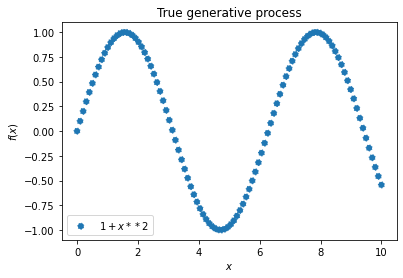

Coefficienct of determination :  0.9999999999970975
Coefficienct of determination From scratch:  -0.015399876947565838
Coefficienct of determination From Sklearn:  -0.7474112257301964


C:\Users\Robert\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [200]:
%matplotlib inline
string = "random function"
def f(x, noise_amount):
    y = function(x,9)
    noise = np.random.normal(0, 1, len(x))
    return y + noise_amount * noise

# dataset
def dataset(samples,features,choice = 0):
    X = np.linspace(0, 10, 100)
    y = f(X, noise_amount=0)
    X = X[:, np.newaxis]
    y = y[:, np.newaxis]
    return X,y


# plot
def plot(samples,features,choice =0 ):
    X,y = dataset(samples,features,choice)
    plt.scatter(X, y, label=r"$1 + x**2$", linestyle="dotted")
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    _ = plt.title("True generative process")
    plt.show()
    
# dataset generation and splitting
def dataset_validation(X,y,split,choice = 0):
    if choice != 0:
        X = sklearn.metrics.pairwise.pairwise_kernels(X,X)
    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    scaler1 = preprocessing.StandardScaler().fit(y)
    y = scaler1.transform(y)
    rng = np.random.RandomState(1)
    size_samples = int(split*y.size)
    training_indices = rng.choice(np.arange(y.size), size=size_samples, replace=False)
    X_train, y_train = X[training_indices], y[training_indices]
    test_indices = np.setdiff1d(np.arange(y.size),training_indices)
    X_test, y_test = X[test_indices],y[test_indices]
    return X,y,X_train,y_train,X_test,y_test
# dataset
X,y = dataset(1000,3)
plot(1000,2)
# gaussian processes
X,y,X_train,y_train,X_test_gp,y_test_gp = dataset_validation(X,y,0.7)
kernel = 1 * RBF(length_scale=1,length_scale_bounds = "fixed") #+ WhiteKernel()
gaussian_process = GaussianProcessRegressor(kernel=kernel)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_
print("Coefficienct of determination : ", gaussian_process.score(X_test_gp,y_test_gp))
mean1_gp = gaussian_process.predict(X_test_gp)
X1,y1,X_train,y_train,X_test_bl,y_test_bl = dataset_validation(X,y,0.7,1)
linear_bayes_reg = BayesianLinearRegression()
linear_bayes_reg.fit(X_train, y_train)
lb = linear_bayes_reg.r(X_test_bl, y_test_bl)
print("Coefficienct of determination From scratch: ",lb)
#print(linear_bayes_reg.predict(X_test_bl))
# bayesian linear regression using kernel features
X1,y1,X_train,y_train,X_test_bl,y_test_bl = dataset_validation(X,y,0.7,1)
# can manually change the hyperparameters
#reg = linear_model.BayesianRidge()
reg = linear_model.BayesianRidge()#alpha_init = 1e1,lambda_init=1e-10,compute_score=True)
reg.fit(X_train, y_train)
print("Coefficienct of determination From Sklearn: ", reg.score(X_test_bl,y_test_bl))

In [201]:
alpha = [0.01,1,0.02,0.001,0.001,0.0001,10,100,1000,10000,1000000]
beta = [0.01,1,0.02,0.001,0.001,0.0001,10,100,1000,100000,1000000]
max_lb = -10000
for i in alpha:
    for j in beta:
        linear_bayes_reg = BayesianLinearRegression(i,j)
        linear_bayes_reg.fit(X_train, y_train)
        lb = linear_bayes_reg.r(X_test_bl, y_test_bl)
        if lb > max_lb:
            max_lb = lb
            print(i,j)
            print("Coefficienct of determination From scratch: ",lb)

0.01 0.01
Coefficienct of determination From scratch:  -0.015399876947577162
0.01 0.001
Coefficienct of determination From scratch:  -0.015377303838136624
0.01 0.0001
Coefficienct of determination From scratch:  -0.015155136081180354
1 0.01
Coefficienct of determination From scratch:  -0.015155136081180132
1 0.001
Coefficienct of determination From scratch:  -0.013240373386158355
1 0.0001
Coefficienct of determination From scratch:  -0.005836519834077736
10 0.0001
Coefficienct of determination From scratch:  -0.000883326266518436
100 0.0001
Coefficienct of determination From scratch:  -9.309440250948597e-05
1000 0.0001
Coefficienct of determination From scratch:  -9.359863509805777e-06
10000 0.0001
Coefficienct of determination From scratch:  -9.364935535938201e-07
1000000 0.001
Coefficienct of determination From scratch:  -9.365443043307664e-08
1000000 0.0001
Coefficienct of determination From scratch:  -9.365493713886508e-09


<Figure size 648x432 with 0 Axes>

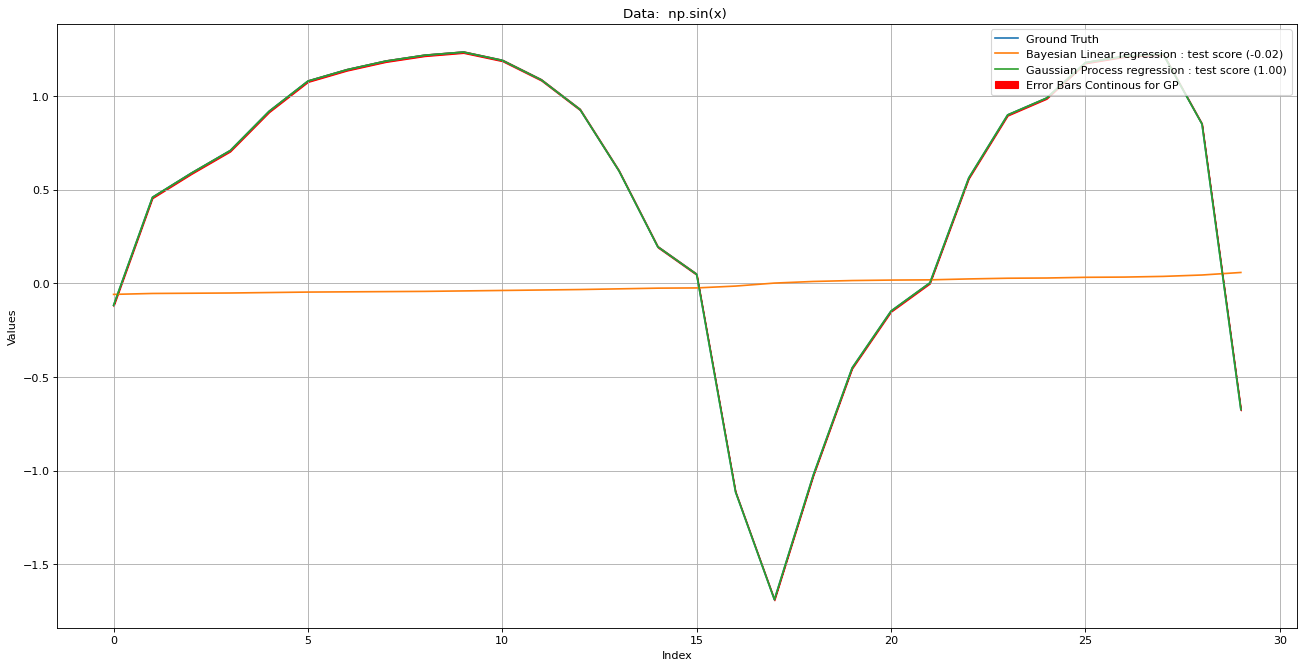

In [202]:
X1,y1,X_train,y_train,X_test_bl,y_test_bl = dataset_validation(X,y,0.7,1)
linear_bayes_reg = BayesianLinearRegression()
linear_bayes_reg.fit(X_train, y_train)

lb = linear_bayes_reg.r(X_test_bl, y_test_bl)
#lb = lb.tolist()
#lb = pow(sum(lb[0])/len(lb[0]),0.5)
linear_bayes_predictions = linear_bayes_reg.predict(X_test_bl)

linear_gp_test = float(gaussian_process.score(X_test_gp,y_test_gp))
mean_prediction_gp, std_prediction_gp = gaussian_process.predict(X_test_gp, return_std=True)
y_mean, y_std = gaussian_process.predict(X_test_gp, return_std=True)

plt.figure(3, figsize=(9, 6))
# only take few samples for the plot
label_linear_bayes = 'Bayesian Linear regression : test score ({:.2f})'.format(lb)
label_gp = 'Gaussian Process regression : test score ({:.2f})'.format(linear_gp_test)

dyfit = 2*np.sqrt(y_std)


figure(figsize=(20, 10), dpi=80)
samples = min(100, len(y_test_bl))
x = range(samples)
plt.plot(x, y_test_gp[0:samples], label='Ground Truth')
plt.plot(x, linear_bayes_predictions[0:samples], label=label_linear_bayes)
plt.plot(x, mean_prediction_gp[0:samples], label=label_gp)
plt.fill_between(x, y_mean.squeeze() - dyfit , y_mean.squeeze() + dyfit, color = 'red', alpha = 1,label = 'Error Bars Continous for GP')
plt.title('Data:  np.sin(x) without noise ')
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend(loc='upper right', prop={'size': 10})
plt.grid()
plt.show()